In [1]:
import requests
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import time
from bs4 import BeautifulSoup as bs
import pandas as pd
import re


class TheWashingtonPost():
    
    def __init__(self):
        self.session = requests.Session()
        self.options = Options()
        self.options.add_argument('--headless')
        self.options.add_argument("--start-maximized")
        self.driver = webdriver.Chrome(ChromeDriverManager().install(), options=self.options)
        self.base_url = 'https://www.washingtonpost.com'
        self.category = ''
        self.sub_category = ''
        self.sleep = 10
        self.data = []
        
    def parse(self):
        self.driver.delete_all_cookies()
        self.driver.get(self.base_url)

        time.sleep(self.sleep)

        self.driver.find_element_by_class_name('transition-color').click()
        html = self.driver.page_source
        self.driver.quit()
        soup = bs(html)
        
        for nav_elements in soup.find('nav', class_='side-nav').findAll('div', class_='bold')[0:2]:
            if len(nav_elements.findAll('li', class_='gray-dark')) > 0:
                self.category = nav_elements.find('a').text
                for link in nav_elements.findAll('li', class_='gray-dark')[0:3]:
                    self.sub_category = link.find('a').text
                    self.parse_category_page(link.find('a')['href'])
            else:
                self.category = nav_elements.find('a').text
                self.sub_category = ''
                self.parse_category_page(nav_elements.find('a')['href'])
                    
        df = pd.DataFrame(self.data, columns=['category', 'sub_category', 'title', 'teaser content', 'article_body','By'])
        df.to_csv('the_washington_post.csv', index=False)
                    
    def parse_category_page(self, link):
        response = self.session.get(link)
        soup = bs(response.text)
        
        for h2 in soup.findAll('h2'):
            try:
                self.parse_article_page(h2.a['href'])
            except:
                pass
        
    def parse_article_page(self, link):
        print(link)
        response = self.session.get(link)
        soup = bs(response.text)
        
        try:
            title = soup.find('h1').text
            print(title)
            try:
                by = ""
                bys = soup.findAll("span",{"data-qa":"author-name-wrapper"})
                for i in bys:
                    if i == bys[-1]:
                        by += i.find("span").text
                    else:
                        by += i.find("span").text + ","
            except Exception as e:
                print(e)
                by = ""
            print(by)
            try:
                teaser_content = ' '.join(div.text for div in soup.find('div', class_='teaser-content').findAll('div')[1:])
            except:
                teaser_content = ''
            article_body = ' '.join(div.text for div in soup.find('div', class_='remainder-content').findAll('div'))
            print(article_body)
            self.data.append([self.category, self.sub_category, title, teaser_content, article_body,by])
            print(len(self.data))
            df = pd.DataFrame(self.data, columns=['category', 'sub_category', 'title', 'teaser content', 'article_body','By'])
            df.to_csv('the_washington_post.csv',mode="a", index=False)
            print(self.data)
        except:
            pass

In [ ]:
twp = TheWashingtonPost()
twp.parse()

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
import emoji
from nltk.tokenize import word_tokenize
import nltk
from textblob import TextBlob
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1123)>


False

In [3]:
# !python -m spacy download en_core_web_trf

     |████████████████████████████████| 459.7 MB 13 kB/s  eta 0:00:015    |█████████▌                      | 135.9 MB 589 kB/s eta 0:09:10     |█████████▉                      | 141.6 MB 1.3 MB/s eta 0:04:00
     |████████████████████████████████| 64 kB 88 kB/s  eta 0:00:011
     |████████████████████████████████| 977 kB 971 kB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 204 kB/s eta 0:00:01
     |████████████████████████████████| 883 kB 4.6 MB/s eta 0:00:01
  Created wheel for ftfy: filename=ftfy-5.8-py3-none-any.whl size=45613 sha256=0a5622f491db8ab2e1a7d250c7c64953546d05f14bc3ae98268d69811e040f02
  Stored in directory: /home/captin-rao/.cache/pip/wheels/3f/a5/65/684a672b6a26cb8ce3934d155c98d0e23b3dce3d2c0fadae19
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7533 sha256=964ddda1e8a0923da6f514602fe4deb8b3b51d1fa27b0c43d77ce738cd17800f
  Stored in directory: /home/

  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893258 sha256=861729903770601c97974153aa4dd3a91cee202e9908d3c129855285108ad634
  Stored in directory: /home/captin-rao/.cache/pip/wheels/7b/78/f4/27d43a65043e1b75dbddaa421b573eddc67e712be4b1c80677
Successfully built ftfy torchcontrib sacremoses
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [13]:
import en_core_web_trf
nlp = en_core_web_trf.load()
nlp.max_length = 1000000000

In [4]:
df = pd.read_csv('the_washington_post.csv')
df.head()

,category,sub_category,title,teaser content,article_body
0,Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...
1,Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...
2,Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...
3,Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...
4,Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private..."


In [5]:
df = df.replace(np.nan, '')
df.head()

,category,sub_category,title,teaser content,article_body
0,Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...
1,Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...
2,Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...
3,Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...
4,Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private..."


In [6]:
df.drop_duplicates(keep=False, inplace=True)
df.reset_index(inplace = True, drop = True)

In [8]:
df['complete_article'] = df['title'].str.cat(df[['teaser content', 'article_body']], sep=' ')
df.head()

,category,sub_category,title,teaser content,article_body,complete_article
0,Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...,The Daily 202: Biden’s Yemen policy breaks wit...
1,Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...,The Technology 202: Tech companies will be tak...
2,Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...,The Energy 202: How Democrats may try getting ...
3,Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...,The Health 202: Biden narrows picks to lead Me...
4,Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private...",The Cybersecurity 202: Coronavirus pandemic re...


## Frequency Plot and Word Cloud before Data Cleaning

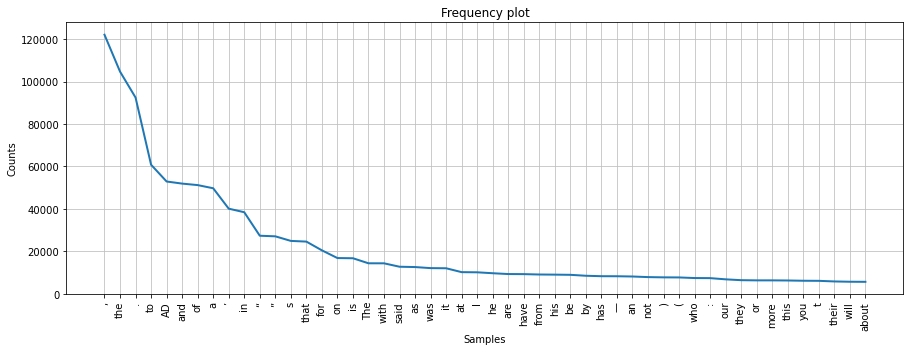

<AxesSubplot:title={'center':'Frequency plot'}, xlabel='Samples', ylabel='Counts'>

In [9]:
comment = ' '.join(df["complete_article"])
#function to split text into word
tokens = word_tokenize(comment)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)
plt.subplots(figsize=(15,5))
frequency_dist.plot(50,cumulative=False,title='Frequency plot')

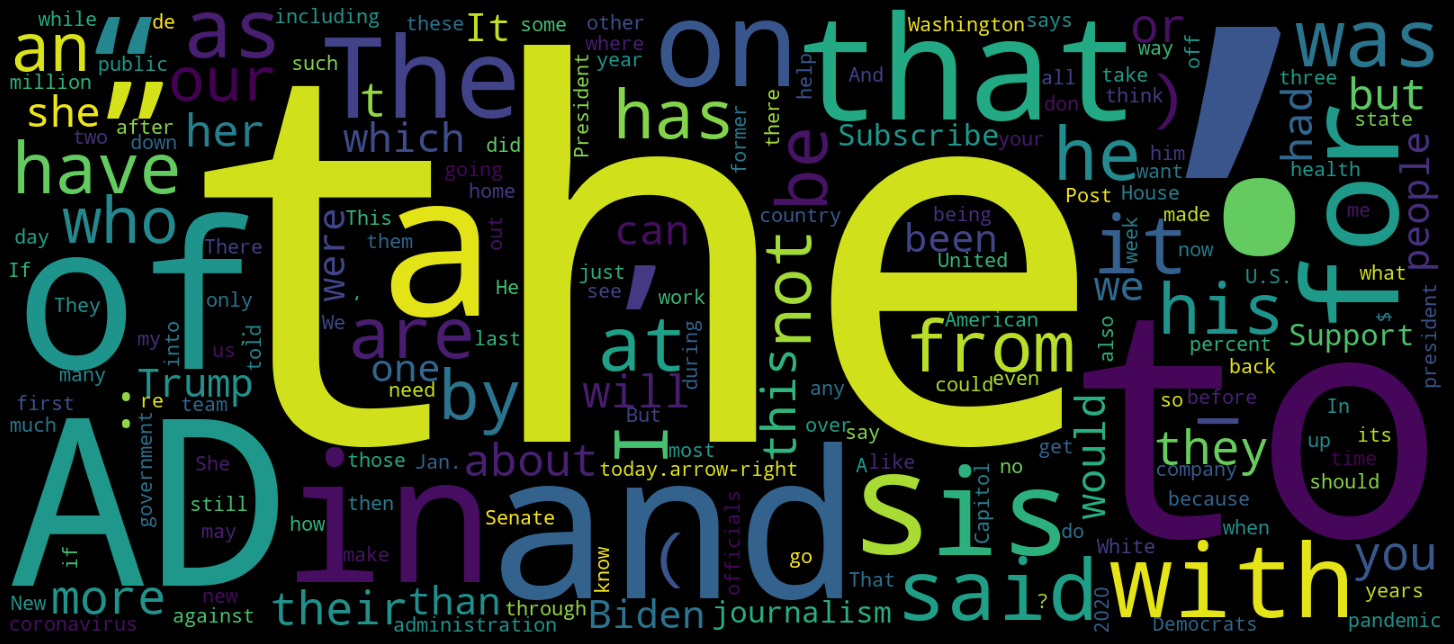

In [10]:
wordcloud = WordCloud(width=1600, height=700).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Preprocessing

In [75]:
def clean_text(text,replace=''):
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    text = emoji.demojize(str(text))
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"http\S+", "", text)  # removes URL from string
    text = re.compile("\\b(ad|nt|s)\\W", re.I).sub("", text)
    text = " ".join([word.lemma_ for word in nlp(text) if not word.is_stop if not word.is_punct])
    text = " ".join(re.split("\s+", text, flags=re.UNICODE))
    return text

In [76]:
df['complete_article'] = df['complete_article'].apply(clean_text)

In [77]:
df.head()

,category,sub_category,title,teaser content,article_body,complete_article
0,Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...,daily bidens yemen policy break obama daylight...
1,Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...,technology tech company airwave super bowl lv ...
2,Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...,energy democrats try filibuster climate change...
3,Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...,health biden narrow pick lead medicare medicai...
4,Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private...",cybersecurity coronavirus pandemic renew debat...


## Frequency Plot and Word Cloud after Data Cleaning

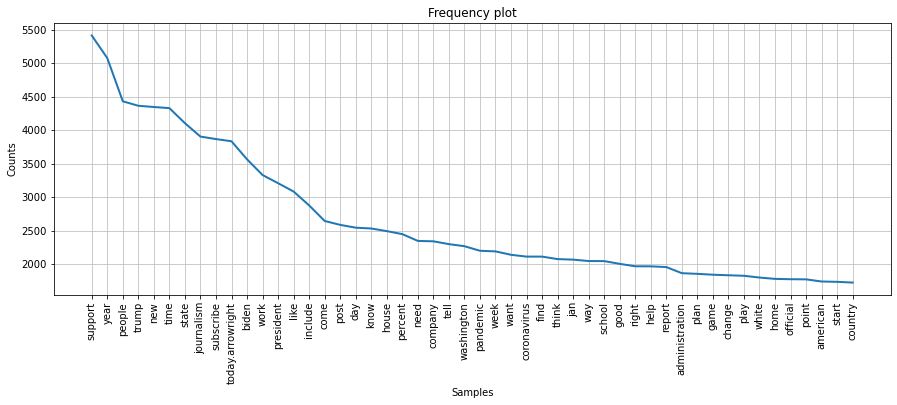

<AxesSubplot:title={'center':'Frequency plot'}, xlabel='Samples', ylabel='Counts'>

In [78]:
comment = ' '.join(df["complete_article"])
#function to split text into word
tokens = word_tokenize(comment)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)
plt.subplots(figsize=(15,5))
frequency_dist.plot(50,cumulative=False,title='Frequency plot')

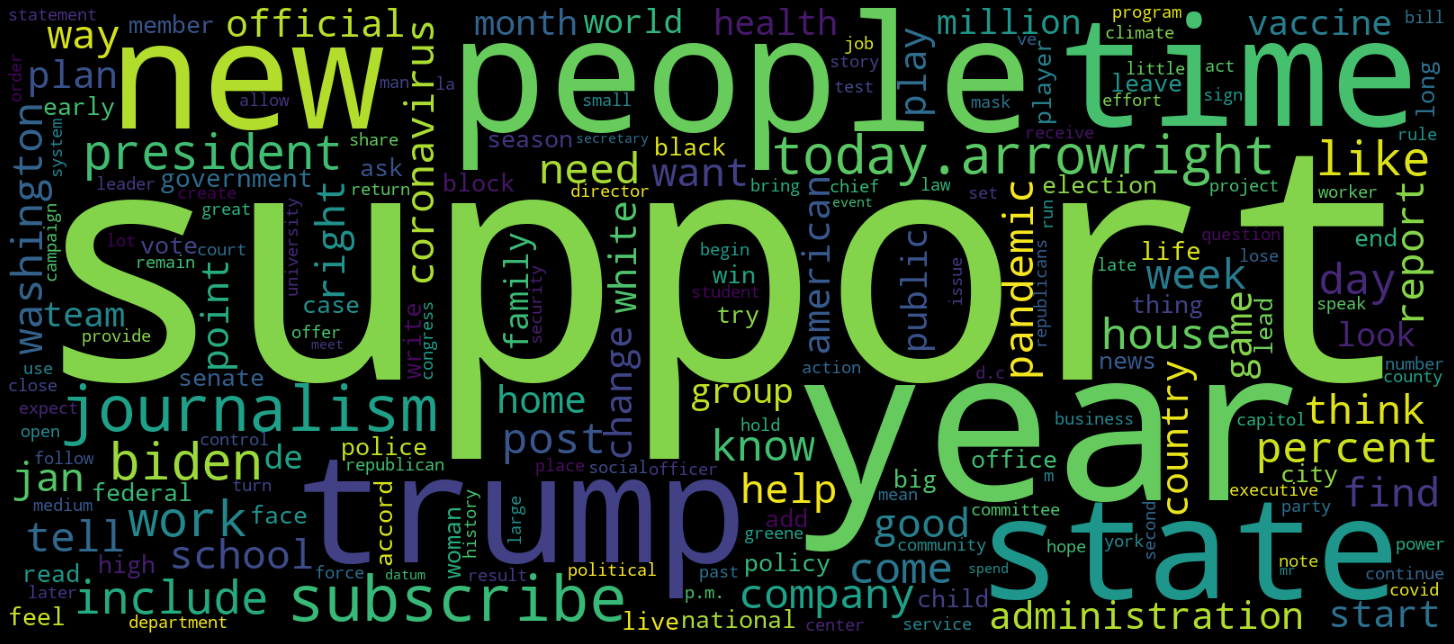

In [79]:
wordcloud = WordCloud(width=1600, height=700).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Sentiment Analysis

In [80]:
sentiment = []

for text in df["complete_article"]:    
    blob = TextBlob(text)
    for sentence in blob.sentences:
        if sentence.sentiment.polarity > 0.0:
            sentiment.append('positive')
        elif sentence.sentiment.polarity < 0.0:
            sentiment.append('negative')
        else:
            sentiment.append('neutral')

df_sentiment = df.copy()
df_sentiment['target'] = pd.DataFrame(sentiment)
df_sentiment.head()

,category,sub_category,title,teaser content,article_body,complete_article,target
0,Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...,daily bidens yemen policy break obama daylight...,negative
1,Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...,technology tech company airwave super bowl lv ...,positive
2,Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...,energy democrats try filibuster climate change...,positive
3,Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...,health biden narrow pick lead medicare medicai...,positive
4,Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private...",cybersecurity coronavirus pandemic renew debat...,positive


<AxesSubplot:>

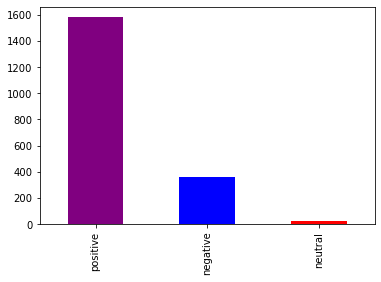

In [81]:
df_sentiment.target.value_counts().plot(kind='bar', color=['purple', 'blue', 'red'])

In [132]:
df_sentiment.to_csv('washington_post_positive_negative_sentiment_analysis.csv', index=False)

## Nuanced Sentiment Analysis

In [82]:
import text2emotion as te

In [83]:
emotions = []
for article in df["complete_article"]:
    emotion = te.get_emotion(article)
    print(emotion)
    emotions.append(emotion)
    print(len(emotions))

{'Happy': 0.09, 'Angry': 0.03, 'Surprise': 0.21, 'Sad': 0.26, 'Fear': 0.41}
1
{'Happy': 0.08, 'Angry': 0.04, 'Surprise': 0.15, 'Sad': 0.17, 'Fear': 0.55}
2
{'Happy': 0.05, 'Angry': 0.08, 'Surprise': 0.18, 'Sad': 0.16, 'Fear': 0.52}
3
{'Happy': 0.11, 'Angry': 0.05, 'Surprise': 0.18, 'Sad': 0.17, 'Fear': 0.48}
4
{'Happy': 0.06, 'Angry': 0.05, 'Surprise': 0.14, 'Sad': 0.16, 'Fear': 0.59}
5
{'Happy': 0.09, 'Angry': 0.04, 'Surprise': 0.19, 'Sad': 0.2, 'Fear': 0.48}
6
{'Happy': 0.03, 'Angry': 0.03, 'Surprise': 0.3, 'Sad': 0.27, 'Fear': 0.38}
7
{'Happy': 0.12, 'Angry': 0.04, 'Surprise': 0.16, 'Sad': 0.27, 'Fear': 0.4}
8
{'Happy': 0.08, 'Angry': 0.05, 'Surprise': 0.21, 'Sad': 0.21, 'Fear': 0.46}
9
{'Happy': 0.09, 'Angry': 0.07, 'Surprise': 0.12, 'Sad': 0.23, 'Fear': 0.5}
10
{'Happy': 0.09, 'Angry': 0.01, 'Surprise': 0.17, 'Sad': 0.26, 'Fear': 0.47}
11
{'Happy': 0.05, 'Angry': 0.02, 'Surprise': 0.18, 'Sad': 0.18, 'Fear': 0.56}
12
{'Happy': 0.09, 'Angry': 0.04, 'Surprise': 0.19, 'Sad': 0.21, 'Fe

{'Happy': 0.11, 'Angry': 0.06, 'Surprise': 0.18, 'Sad': 0.13, 'Fear': 0.52}
106
{'Happy': 0.05, 'Angry': 0.02, 'Surprise': 0.32, 'Sad': 0.14, 'Fear': 0.47}
107
{'Happy': 0.12, 'Angry': 0.05, 'Surprise': 0.18, 'Sad': 0.12, 'Fear': 0.54}
108
{'Happy': 0.11, 'Angry': 0.05, 'Surprise': 0.17, 'Sad': 0.14, 'Fear': 0.53}
109
{'Happy': 0.04, 'Angry': 0.01, 'Surprise': 0.08, 'Sad': 0.32, 'Fear': 0.54}
110
{'Happy': 0.09, 'Angry': 0.09, 'Surprise': 0.16, 'Sad': 0.23, 'Fear': 0.44}
111
{'Happy': 0.1, 'Angry': 0.06, 'Surprise': 0.16, 'Sad': 0.18, 'Fear': 0.5}
112
{'Happy': 0.11, 'Angry': 0.02, 'Surprise': 0.22, 'Sad': 0.24, 'Fear': 0.41}
113
{'Happy': 0.11, 'Angry': 0.01, 'Surprise': 0.1, 'Sad': 0.15, 'Fear': 0.62}
114
{'Happy': 0.08, 'Angry': 0.02, 'Surprise': 0.32, 'Sad': 0.19, 'Fear': 0.4}
115
{'Happy': 0.06, 'Angry': 0.08, 'Surprise': 0.14, 'Sad': 0.16, 'Fear': 0.55}
116
{'Happy': 0.11, 'Angry': 0.09, 'Surprise': 0.26, 'Sad': 0.15, 'Fear': 0.38}
117
{'Happy': 0.09, 'Angry': 0.06, 'Surprise': 0

{'Happy': 0.07, 'Angry': 0.05, 'Surprise': 0.28, 'Sad': 0.23, 'Fear': 0.36}
211
{'Happy': 0.09, 'Angry': 0.0, 'Surprise': 0.16, 'Sad': 0.16, 'Fear': 0.6}
212
{'Happy': 0.13, 'Angry': 0.01, 'Surprise': 0.17, 'Sad': 0.22, 'Fear': 0.46}
213
{'Happy': 0.11, 'Angry': 0.09, 'Surprise': 0.19, 'Sad': 0.3, 'Fear': 0.3}
214
{'Happy': 0.09, 'Angry': 0.03, 'Surprise': 0.25, 'Sad': 0.12, 'Fear': 0.51}
215
{'Happy': 0.19, 'Angry': 0.05, 'Surprise': 0.16, 'Sad': 0.22, 'Fear': 0.38}
216
{'Happy': 0.13, 'Angry': 0.11, 'Surprise': 0.16, 'Sad': 0.17, 'Fear': 0.43}
217
{'Happy': 0.03, 'Angry': 0.04, 'Surprise': 0.35, 'Sad': 0.1, 'Fear': 0.47}
218
{'Happy': 0.09, 'Angry': 0.08, 'Surprise': 0.13, 'Sad': 0.29, 'Fear': 0.4}
219
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 1.0}
220
{'Happy': 0.0, 'Angry': 0.11, 'Surprise': 0.11, 'Sad': 0.11, 'Fear': 0.67}
221
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.42, 'Sad': 0.11, 'Fear': 0.47}
222
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.11, 'Sad': 

{'Happy': 0.08, 'Angry': 0.01, 'Surprise': 0.14, 'Sad': 0.22, 'Fear': 0.55}
315
{'Happy': 0.06, 'Angry': 0.1, 'Surprise': 0.18, 'Sad': 0.21, 'Fear': 0.45}
316
{'Happy': 0.05, 'Angry': 0.04, 'Surprise': 0.23, 'Sad': 0.29, 'Fear': 0.38}
317
{'Happy': 0.1, 'Angry': 0.07, 'Surprise': 0.18, 'Sad': 0.1, 'Fear': 0.56}
318
{'Happy': 0.07, 'Angry': 0.0, 'Surprise': 0.14, 'Sad': 0.25, 'Fear': 0.55}
319
{'Happy': 0.07, 'Angry': 0.06, 'Surprise': 0.13, 'Sad': 0.23, 'Fear': 0.51}
320
{'Happy': 0.05, 'Angry': 0.08, 'Surprise': 0.13, 'Sad': 0.09, 'Fear': 0.65}
321
{'Happy': 0.03, 'Angry': 0.08, 'Surprise': 0.19, 'Sad': 0.17, 'Fear': 0.52}
322
{'Happy': 0.14, 'Angry': 0.02, 'Surprise': 0.17, 'Sad': 0.12, 'Fear': 0.56}
323
{'Happy': 0.06, 'Angry': 0.04, 'Surprise': 0.24, 'Sad': 0.16, 'Fear': 0.49}
324
{'Happy': 0.16, 'Angry': 0.02, 'Surprise': 0.12, 'Sad': 0.15, 'Fear': 0.55}
325
{'Happy': 0.08, 'Angry': 0.03, 'Surprise': 0.07, 'Sad': 0.08, 'Fear': 0.74}
326
{'Happy': 0.11, 'Angry': 0.0, 'Surprise': 0.

{'Happy': 0.13, 'Angry': 0.02, 'Surprise': 0.23, 'Sad': 0.17, 'Fear': 0.46}
418
{'Happy': 0.11, 'Angry': 0.03, 'Surprise': 0.19, 'Sad': 0.2, 'Fear': 0.47}
419
{'Happy': 0.05, 'Angry': 0.02, 'Surprise': 0.32, 'Sad': 0.14, 'Fear': 0.47}
420
{'Happy': 0.08, 'Angry': 0.04, 'Surprise': 0.17, 'Sad': 0.2, 'Fear': 0.51}
421
{'Happy': 0.12, 'Angry': 0.1, 'Surprise': 0.18, 'Sad': 0.21, 'Fear': 0.39}
422
{'Happy': 0.05, 'Angry': 0.02, 'Surprise': 0.18, 'Sad': 0.22, 'Fear': 0.54}
423
{'Happy': 0.05, 'Angry': 0.02, 'Surprise': 0.27, 'Sad': 0.17, 'Fear': 0.49}
424
{'Happy': 0.1, 'Angry': 0.03, 'Surprise': 0.16, 'Sad': 0.17, 'Fear': 0.54}
425
{'Happy': 0.07, 'Angry': 0.05, 'Surprise': 0.15, 'Sad': 0.22, 'Fear': 0.5}
426
{'Happy': 0.08, 'Angry': 0.04, 'Surprise': 0.12, 'Sad': 0.25, 'Fear': 0.51}
427
{'Happy': 0.19, 'Angry': 0.03, 'Surprise': 0.11, 'Sad': 0.21, 'Fear': 0.46}
428
{'Happy': 0.13, 'Angry': 0.06, 'Surprise': 0.16, 'Sad': 0.24, 'Fear': 0.41}
429
{'Happy': 0.14, 'Angry': 0.04, 'Surprise': 0.

{'Happy': 0.11, 'Angry': 0.07, 'Surprise': 0.18, 'Sad': 0.15, 'Fear': 0.48}
522
{'Happy': 0.1, 'Angry': 0.02, 'Surprise': 0.15, 'Sad': 0.27, 'Fear': 0.45}
523
{'Happy': 0.0, 'Angry': 0.11, 'Surprise': 0.22, 'Sad': 0.44, 'Fear': 0.22}
524
{'Happy': 0.06, 'Angry': 0.06, 'Surprise': 0.12, 'Sad': 0.17, 'Fear': 0.58}
525
{'Happy': 0.15, 'Angry': 0.0, 'Surprise': 0.19, 'Sad': 0.19, 'Fear': 0.46}
526
{'Happy': 0.07, 'Angry': 0.03, 'Surprise': 0.07, 'Sad': 0.28, 'Fear': 0.54}
527
{'Happy': 0.15, 'Angry': 0.11, 'Surprise': 0.12, 'Sad': 0.18, 'Fear': 0.43}
528
{'Happy': 0.1, 'Angry': 0.05, 'Surprise': 0.14, 'Sad': 0.27, 'Fear': 0.44}
529
{'Happy': 0.08, 'Angry': 0.06, 'Surprise': 0.14, 'Sad': 0.22, 'Fear': 0.5}
530
{'Happy': 0.06, 'Angry': 0.02, 'Surprise': 0.09, 'Sad': 0.33, 'Fear': 0.49}
531
{'Happy': 0.0, 'Angry': 0.08, 'Surprise': 0.08, 'Sad': 0.42, 'Fear': 0.42}
532
{'Happy': 0.06, 'Angry': 0.06, 'Surprise': 0.12, 'Sad': 0.12, 'Fear': 0.65}
533
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.55,

{'Happy': 0.12, 'Angry': 0.1, 'Surprise': 0.12, 'Sad': 0.21, 'Fear': 0.45}
626
{'Happy': 0.16, 'Angry': 0.05, 'Surprise': 0.1, 'Sad': 0.34, 'Fear': 0.34}
627
{'Happy': 0.09, 'Angry': 0.07, 'Surprise': 0.22, 'Sad': 0.16, 'Fear': 0.46}
628
{'Happy': 0.08, 'Angry': 0.04, 'Surprise': 0.17, 'Sad': 0.34, 'Fear': 0.38}
629
{'Happy': 0.12, 'Angry': 0.0, 'Surprise': 0.12, 'Sad': 0.12, 'Fear': 0.62}
630
{'Happy': 0.21, 'Angry': 0.07, 'Surprise': 0.36, 'Sad': 0.07, 'Fear': 0.29}
631
{'Happy': 0.18, 'Angry': 0.04, 'Surprise': 0.11, 'Sad': 0.14, 'Fear': 0.54}
632
{'Happy': 0.07, 'Angry': 0.06, 'Surprise': 0.11, 'Sad': 0.11, 'Fear': 0.65}
633
{'Happy': 0.1, 'Angry': 0.11, 'Surprise': 0.11, 'Sad': 0.16, 'Fear': 0.52}
634
{'Happy': 0.11, 'Angry': 0.02, 'Surprise': 0.21, 'Sad': 0.13, 'Fear': 0.53}
635
{'Happy': 0.13, 'Angry': 0.04, 'Surprise': 0.14, 'Sad': 0.17, 'Fear': 0.52}
636
{'Happy': 0.11, 'Angry': 0.04, 'Surprise': 0.13, 'Sad': 0.14, 'Fear': 0.57}
637
{'Happy': 0.06, 'Angry': 0.06, 'Surprise': 0

{'Happy': 0.11, 'Angry': 0.09, 'Surprise': 0.16, 'Sad': 0.11, 'Fear': 0.54}
730
{'Happy': 0.29, 'Angry': 0.12, 'Surprise': 0.06, 'Sad': 0.24, 'Fear': 0.29}
731
{'Happy': 0.17, 'Angry': 0.05, 'Surprise': 0.13, 'Sad': 0.15, 'Fear': 0.49}
732
{'Happy': 0.12, 'Angry': 0.05, 'Surprise': 0.31, 'Sad': 0.17, 'Fear': 0.36}
733
{'Happy': 0.0, 'Angry': 0.16, 'Surprise': 0.26, 'Sad': 0.16, 'Fear': 0.42}
734
{'Happy': 0.16, 'Angry': 0.21, 'Surprise': 0.0, 'Sad': 0.11, 'Fear': 0.53}
735
{'Happy': 0.13, 'Angry': 0.13, 'Surprise': 0.0, 'Sad': 0.13, 'Fear': 0.6}
736
{'Happy': 0.06, 'Angry': 0.17, 'Surprise': 0.13, 'Sad': 0.13, 'Fear': 0.51}
737
{'Happy': 0.07, 'Angry': 0.1, 'Surprise': 0.17, 'Sad': 0.17, 'Fear': 0.48}
738
{'Happy': 0.15, 'Angry': 0.08, 'Surprise': 0.17, 'Sad': 0.26, 'Fear': 0.35}
739
{'Happy': 0.13, 'Angry': 0.04, 'Surprise': 0.13, 'Sad': 0.29, 'Fear': 0.41}
740
{'Happy': 0.1, 'Angry': 0.05, 'Surprise': 0.15, 'Sad': 0.27, 'Fear': 0.42}
741
{'Happy': 0.09, 'Angry': 0.06, 'Surprise': 0.1

{'Happy': 0.22, 'Angry': 0.04, 'Surprise': 0.22, 'Sad': 0.22, 'Fear': 0.3}
834
{'Happy': 0.22, 'Angry': 0.06, 'Surprise': 0.11, 'Sad': 0.2, 'Fear': 0.41}
835
{'Happy': 0.29, 'Angry': 0.0, 'Surprise': 0.12, 'Sad': 0.06, 'Fear': 0.52}
836
{'Happy': 0.05, 'Angry': 0.02, 'Surprise': 0.21, 'Sad': 0.23, 'Fear': 0.49}
837
{'Happy': 0.13, 'Angry': 0.04, 'Surprise': 0.13, 'Sad': 0.35, 'Fear': 0.35}
838
{'Happy': 0.2, 'Angry': 0.07, 'Surprise': 0.14, 'Sad': 0.16, 'Fear': 0.43}
839
{'Happy': 0.04, 'Angry': 0.04, 'Surprise': 0.25, 'Sad': 0.25, 'Fear': 0.42}
840
{'Happy': 0.32, 'Angry': 0.1, 'Surprise': 0.07, 'Sad': 0.15, 'Fear': 0.36}
841
{'Happy': 0.14, 'Angry': 0.09, 'Surprise': 0.18, 'Sad': 0.17, 'Fear': 0.42}
842
{'Happy': 0.14, 'Angry': 0.03, 'Surprise': 0.18, 'Sad': 0.18, 'Fear': 0.47}
843
{'Happy': 0.17, 'Angry': 0.03, 'Surprise': 0.11, 'Sad': 0.15, 'Fear': 0.54}
844
{'Happy': 0.04, 'Angry': 0.08, 'Surprise': 0.25, 'Sad': 0.15, 'Fear': 0.48}
845
{'Happy': 0.15, 'Angry': 0.03, 'Surprise': 0.

{'Happy': 0.18, 'Angry': 0.04, 'Surprise': 0.26, 'Sad': 0.12, 'Fear': 0.39}
938
{'Happy': 0.04, 'Angry': 0.1, 'Surprise': 0.15, 'Sad': 0.26, 'Fear': 0.46}
939
{'Happy': 0.11, 'Angry': 0.04, 'Surprise': 0.19, 'Sad': 0.21, 'Fear': 0.45}
940
{'Happy': 0.08, 'Angry': 0.03, 'Surprise': 0.29, 'Sad': 0.22, 'Fear': 0.38}
941
{'Happy': 0.1, 'Angry': 0.03, 'Surprise': 0.24, 'Sad': 0.14, 'Fear': 0.49}
942
{'Happy': 0.04, 'Angry': 0.01, 'Surprise': 0.08, 'Sad': 0.32, 'Fear': 0.54}
943
{'Happy': 0.09, 'Angry': 0.07, 'Surprise': 0.14, 'Sad': 0.17, 'Fear': 0.53}
944
{'Happy': 0.04, 'Angry': 0.01, 'Surprise': 0.15, 'Sad': 0.21, 'Fear': 0.58}
945
{'Happy': 0.07, 'Angry': 0.04, 'Surprise': 0.18, 'Sad': 0.26, 'Fear': 0.45}
946
{'Happy': 0.11, 'Angry': 0.02, 'Surprise': 0.12, 'Sad': 0.2, 'Fear': 0.54}
947
{'Happy': 0.03, 'Angry': 0.01, 'Surprise': 0.09, 'Sad': 0.17, 'Fear': 0.7}
948
{'Happy': 0.04, 'Angry': 0.12, 'Surprise': 0.13, 'Sad': 0.29, 'Fear': 0.42}
949
{'Happy': 0.09, 'Angry': 0.05, 'Surprise': 0

{'Happy': 0.09, 'Angry': 0.06, 'Surprise': 0.14, 'Sad': 0.29, 'Fear': 0.41}
1041
{'Happy': 0.2, 'Angry': 0.06, 'Surprise': 0.22, 'Sad': 0.18, 'Fear': 0.34}
1042
{'Happy': 0.06, 'Angry': 0.04, 'Surprise': 0.27, 'Sad': 0.31, 'Fear': 0.32}
1043
{'Happy': 0.08, 'Angry': 0.04, 'Surprise': 0.11, 'Sad': 0.16, 'Fear': 0.6}
1044
{'Happy': 0.11, 'Angry': 0.03, 'Surprise': 0.14, 'Sad': 0.2, 'Fear': 0.51}
1045
{'Happy': 0.12, 'Angry': 0.03, 'Surprise': 0.13, 'Sad': 0.27, 'Fear': 0.45}
1046
{'Happy': 0.16, 'Angry': 0.07, 'Surprise': 0.27, 'Sad': 0.19, 'Fear': 0.31}
1047
{'Happy': 0.13, 'Angry': 0.09, 'Surprise': 0.17, 'Sad': 0.15, 'Fear': 0.46}
1048
{'Happy': 0.13, 'Angry': 0.09, 'Surprise': 0.13, 'Sad': 0.22, 'Fear': 0.43}
1049
{'Happy': 0.16, 'Angry': 0.01, 'Surprise': 0.1, 'Sad': 0.27, 'Fear': 0.46}
1050
{'Happy': 0.11, 'Angry': 0.06, 'Surprise': 0.14, 'Sad': 0.23, 'Fear': 0.46}
1051
{'Happy': 0.16, 'Angry': 0.03, 'Surprise': 0.29, 'Sad': 0.19, 'Fear': 0.33}
1052
{'Happy': 0.24, 'Angry': 0.05, '

{'Happy': 0.05, 'Angry': 0.09, 'Surprise': 0.18, 'Sad': 0.23, 'Fear': 0.45}
1143
{'Happy': 0.04, 'Angry': 0.07, 'Surprise': 0.11, 'Sad': 0.16, 'Fear': 0.61}
1144
{'Happy': 0.1, 'Angry': 0.06, 'Surprise': 0.24, 'Sad': 0.12, 'Fear': 0.47}
1145
{'Happy': 0.08, 'Angry': 0.03, 'Surprise': 0.18, 'Sad': 0.34, 'Fear': 0.36}
1146
{'Happy': 0.08, 'Angry': 0.08, 'Surprise': 0.16, 'Sad': 0.11, 'Fear': 0.57}
1147
{'Happy': 0.03, 'Angry': 0.08, 'Surprise': 0.02, 'Sad': 0.11, 'Fear': 0.77}
1148
{'Happy': 0.09, 'Angry': 0.07, 'Surprise': 0.16, 'Sad': 0.14, 'Fear': 0.54}
1149
{'Happy': 0.1, 'Angry': 0.12, 'Surprise': 0.2, 'Sad': 0.1, 'Fear': 0.48}
1150
{'Happy': 0.11, 'Angry': 0.05, 'Surprise': 0.18, 'Sad': 0.17, 'Fear': 0.48}
1151
{'Happy': 0.09, 'Angry': 0.01, 'Surprise': 0.17, 'Sad': 0.26, 'Fear': 0.47}
1152
{'Happy': 0.08, 'Angry': 0.03, 'Surprise': 0.14, 'Sad': 0.31, 'Fear': 0.44}
1153
{'Happy': 0.05, 'Angry': 0.02, 'Surprise': 0.23, 'Sad': 0.35, 'Fear': 0.35}
1154
{'Happy': 0.12, 'Angry': 0.05, '

{'Happy': 0.1, 'Angry': 0.0, 'Surprise': 0.33, 'Sad': 0.03, 'Fear': 0.53}
1245
{'Happy': 0.07, 'Angry': 0.06, 'Surprise': 0.13, 'Sad': 0.2, 'Fear': 0.54}
1246
{'Happy': 0.16, 'Angry': 0.02, 'Surprise': 0.14, 'Sad': 0.13, 'Fear': 0.54}
1247
{'Happy': 0.04, 'Angry': 0.04, 'Surprise': 0.16, 'Sad': 0.13, 'Fear': 0.63}
1248
{'Happy': 0.02, 'Angry': 0.06, 'Surprise': 0.14, 'Sad': 0.06, 'Fear': 0.71}
1249
{'Happy': 0.08, 'Angry': 0.04, 'Surprise': 0.08, 'Sad': 0.23, 'Fear': 0.56}
1250
{'Happy': 0.14, 'Angry': 0.01, 'Surprise': 0.14, 'Sad': 0.3, 'Fear': 0.41}
1251
{'Happy': 0.09, 'Angry': 0.04, 'Surprise': 0.09, 'Sad': 0.2, 'Fear': 0.58}
1252
{'Happy': 0.13, 'Angry': 0.05, 'Surprise': 0.14, 'Sad': 0.19, 'Fear': 0.49}
1253
{'Happy': 0.05, 'Angry': 0.03, 'Surprise': 0.07, 'Sad': 0.1, 'Fear': 0.75}
1254
{'Happy': 0.08, 'Angry': 0.05, 'Surprise': 0.25, 'Sad': 0.1, 'Fear': 0.52}
1255
{'Happy': 0.11, 'Angry': 0.04, 'Surprise': 0.16, 'Sad': 0.14, 'Fear': 0.54}
1256
{'Happy': 0.08, 'Angry': 0.04, 'Sur

{'Happy': 0.19, 'Angry': 0.02, 'Surprise': 0.14, 'Sad': 0.21, 'Fear': 0.43}
1347
{'Happy': 0.1, 'Angry': 0.07, 'Surprise': 0.22, 'Sad': 0.2, 'Fear': 0.41}
1348
{'Happy': 0.12, 'Angry': 0.06, 'Surprise': 0.11, 'Sad': 0.23, 'Fear': 0.48}
1349
{'Happy': 0.15, 'Angry': 0.02, 'Surprise': 0.14, 'Sad': 0.27, 'Fear': 0.42}
1350
{'Happy': 0.14, 'Angry': 0.04, 'Surprise': 0.09, 'Sad': 0.18, 'Fear': 0.54}
1351
{'Happy': 0.26, 'Angry': 0.06, 'Surprise': 0.18, 'Sad': 0.16, 'Fear': 0.34}
1352
{'Happy': 0.17, 'Angry': 0.07, 'Surprise': 0.17, 'Sad': 0.16, 'Fear': 0.42}
1353
{'Happy': 0.19, 'Angry': 0.02, 'Surprise': 0.13, 'Sad': 0.18, 'Fear': 0.47}
1354
{'Happy': 0.21, 'Angry': 0.03, 'Surprise': 0.17, 'Sad': 0.22, 'Fear': 0.37}
1355
{'Happy': 0.25, 'Angry': 0.12, 'Surprise': 0.13, 'Sad': 0.18, 'Fear': 0.31}
1356
{'Happy': 0.12, 'Angry': 0.02, 'Surprise': 0.14, 'Sad': 0.2, 'Fear': 0.51}
1357
{'Happy': 0.1, 'Angry': 0.04, 'Surprise': 0.06, 'Sad': 0.23, 'Fear': 0.58}
1358
{'Happy': 0.09, 'Angry': 0.02, '

{'Happy': 0.13, 'Angry': 0.05, 'Surprise': 0.05, 'Sad': 0.29, 'Fear': 0.48}
1449
{'Happy': 0.1, 'Angry': 0.09, 'Surprise': 0.12, 'Sad': 0.17, 'Fear': 0.52}
1450
{'Happy': 0.06, 'Angry': 0.06, 'Surprise': 0.14, 'Sad': 0.14, 'Fear': 0.59}
1451
{'Happy': 0.09, 'Angry': 0.02, 'Surprise': 0.13, 'Sad': 0.23, 'Fear': 0.53}
1452
{'Happy': 0.03, 'Angry': 0.05, 'Surprise': 0.11, 'Sad': 0.32, 'Fear': 0.49}
1453
{'Happy': 0.1, 'Angry': 0.11, 'Surprise': 0.14, 'Sad': 0.13, 'Fear': 0.52}
1454
{'Happy': 0.07, 'Angry': 0.02, 'Surprise': 0.07, 'Sad': 0.24, 'Fear': 0.6}
1455
{'Happy': 0.15, 'Angry': 0.04, 'Surprise': 0.16, 'Sad': 0.22, 'Fear': 0.44}
1456
{'Happy': 0.1, 'Angry': 0.04, 'Surprise': 0.11, 'Sad': 0.22, 'Fear': 0.53}
1457
{'Happy': 0.1, 'Angry': 0.06, 'Surprise': 0.16, 'Sad': 0.09, 'Fear': 0.58}
1458
{'Happy': 0.11, 'Angry': 0.03, 'Surprise': 0.19, 'Sad': 0.31, 'Fear': 0.36}
1459
{'Happy': 0.08, 'Angry': 0.02, 'Surprise': 0.13, 'Sad': 0.22, 'Fear': 0.55}
1460
{'Happy': 0.07, 'Angry': 0.07, 'S

{'Happy': 0.16, 'Angry': 0.0, 'Surprise': 0.25, 'Sad': 0.25, 'Fear': 0.34}
1551
{'Happy': 0.2, 'Angry': 0.04, 'Surprise': 0.22, 'Sad': 0.33, 'Fear': 0.2}
1552
{'Happy': 0.1, 'Angry': 0.14, 'Surprise': 0.29, 'Sad': 0.12, 'Fear': 0.36}
1553
{'Happy': 0.07, 'Angry': 0.11, 'Surprise': 0.2, 'Sad': 0.14, 'Fear': 0.48}
1554
{'Happy': 0.15, 'Angry': 0.07, 'Surprise': 0.19, 'Sad': 0.11, 'Fear': 0.48}
1555
{'Happy': 0.09, 'Angry': 0.11, 'Surprise': 0.19, 'Sad': 0.22, 'Fear': 0.38}
1556
{'Happy': 0.11, 'Angry': 0.15, 'Surprise': 0.19, 'Sad': 0.17, 'Fear': 0.38}
1557
{'Happy': 0.12, 'Angry': 0.09, 'Surprise': 0.15, 'Sad': 0.25, 'Fear': 0.39}
1558
{'Happy': 0.17, 'Angry': 0.1, 'Surprise': 0.14, 'Sad': 0.17, 'Fear': 0.43}
1559
{'Happy': 0.14, 'Angry': 0.04, 'Surprise': 0.09, 'Sad': 0.18, 'Fear': 0.54}
1560
{'Happy': 0.26, 'Angry': 0.06, 'Surprise': 0.18, 'Sad': 0.16, 'Fear': 0.34}
1561
{'Happy': 0.14, 'Angry': 0.08, 'Surprise': 0.18, 'Sad': 0.24, 'Fear': 0.37}
1562
{'Happy': 0.17, 'Angry': 0.07, 'Su

{'Happy': 0.15, 'Angry': 0.02, 'Surprise': 0.28, 'Sad': 0.2, 'Fear': 0.35}
1653
{'Happy': 0.14, 'Angry': 0.0, 'Surprise': 0.18, 'Sad': 0.29, 'Fear': 0.39}
1654
{'Happy': 0.06, 'Angry': 0.05, 'Surprise': 0.16, 'Sad': 0.09, 'Fear': 0.65}
1655
{'Happy': 0.11, 'Angry': 0.04, 'Surprise': 0.12, 'Sad': 0.27, 'Fear': 0.46}
1656
{'Happy': 0.1, 'Angry': 0.03, 'Surprise': 0.16, 'Sad': 0.32, 'Fear': 0.39}
1657
{'Happy': 0.11, 'Angry': 0.07, 'Surprise': 0.21, 'Sad': 0.18, 'Fear': 0.43}
1658
{'Happy': 0.04, 'Angry': 0.04, 'Surprise': 0.18, 'Sad': 0.24, 'Fear': 0.49}
1659
{'Happy': 0.09, 'Angry': 0.06, 'Surprise': 0.15, 'Sad': 0.28, 'Fear': 0.41}
1660
{'Happy': 0.25, 'Angry': 0.0, 'Surprise': 0.11, 'Sad': 0.21, 'Fear': 0.43}
1661
{'Happy': 0.02, 'Angry': 0.05, 'Surprise': 0.17, 'Sad': 0.33, 'Fear': 0.43}
1662
{'Happy': 0.15, 'Angry': 0.08, 'Surprise': 0.11, 'Sad': 0.21, 'Fear': 0.45}
1663
{'Happy': 0.03, 'Angry': 0.02, 'Surprise': 0.18, 'Sad': 0.3, 'Fear': 0.47}
1664
{'Happy': 0.06, 'Angry': 0.06, 'S

{'Happy': 0.07, 'Angry': 0.03, 'Surprise': 0.32, 'Sad': 0.17, 'Fear': 0.41}
1755
{'Happy': 0.08, 'Angry': 0.07, 'Surprise': 0.15, 'Sad': 0.13, 'Fear': 0.57}
1756
{'Happy': 0.09, 'Angry': 0.06, 'Surprise': 0.15, 'Sad': 0.28, 'Fear': 0.41}
1757
{'Happy': 0.09, 'Angry': 0.01, 'Surprise': 0.14, 'Sad': 0.21, 'Fear': 0.55}
1758
{'Happy': 0.1, 'Angry': 0.07, 'Surprise': 0.2, 'Sad': 0.2, 'Fear': 0.43}
1759
{'Happy': 0.05, 'Angry': 0.05, 'Surprise': 0.18, 'Sad': 0.21, 'Fear': 0.51}
1760
{'Happy': 0.21, 'Angry': 0.05, 'Surprise': 0.12, 'Sad': 0.24, 'Fear': 0.37}
1761
{'Happy': 0.09, 'Angry': 0.05, 'Surprise': 0.3, 'Sad': 0.14, 'Fear': 0.42}
1762
{'Happy': 0.07, 'Angry': 0.04, 'Surprise': 0.32, 'Sad': 0.17, 'Fear': 0.4}
1763
{'Happy': 0.1, 'Angry': 0.06, 'Surprise': 0.46, 'Sad': 0.19, 'Fear': 0.2}
1764
{'Happy': 0.07, 'Angry': 0.03, 'Surprise': 0.3, 'Sad': 0.19, 'Fear': 0.42}
1765
{'Happy': 0.11, 'Angry': 0.06, 'Surprise': 0.14, 'Sad': 0.23, 'Fear': 0.45}
1766
{'Happy': 0.08, 'Angry': 0.03, 'Surp

{'Happy': 0.06, 'Angry': 0.03, 'Surprise': 0.18, 'Sad': 0.37, 'Fear': 0.36}
1857
{'Happy': 0.12, 'Angry': 0.1, 'Surprise': 0.12, 'Sad': 0.21, 'Fear': 0.45}
1858
{'Happy': 0.16, 'Angry': 0.05, 'Surprise': 0.1, 'Sad': 0.34, 'Fear': 0.34}
1859
{'Happy': 0.09, 'Angry': 0.07, 'Surprise': 0.22, 'Sad': 0.16, 'Fear': 0.46}
1860
{'Happy': 0.08, 'Angry': 0.04, 'Surprise': 0.17, 'Sad': 0.34, 'Fear': 0.38}
1861
{'Happy': 0.12, 'Angry': 0.0, 'Surprise': 0.12, 'Sad': 0.12, 'Fear': 0.62}
1862
{'Happy': 0.21, 'Angry': 0.07, 'Surprise': 0.36, 'Sad': 0.07, 'Fear': 0.29}
1863
{'Happy': 0.18, 'Angry': 0.04, 'Surprise': 0.11, 'Sad': 0.14, 'Fear': 0.54}
1864
{'Happy': 0.07, 'Angry': 0.06, 'Surprise': 0.11, 'Sad': 0.11, 'Fear': 0.65}
1865
{'Happy': 0.1, 'Angry': 0.11, 'Surprise': 0.11, 'Sad': 0.16, 'Fear': 0.52}
1866
{'Happy': 0.11, 'Angry': 0.02, 'Surprise': 0.21, 'Sad': 0.13, 'Fear': 0.53}
1867
{'Happy': 0.13, 'Angry': 0.04, 'Surprise': 0.14, 'Sad': 0.17, 'Fear': 0.52}
1868
{'Happy': 0.11, 'Angry': 0.04, '

{'Happy': 0.05, 'Angry': 0.03, 'Surprise': 0.01, 'Sad': 0.29, 'Fear': 0.61}
1960
{'Happy': 0.04, 'Angry': 0.0, 'Surprise': 0.22, 'Sad': 0.16, 'Fear': 0.58}
1961


In [84]:
emotions_df = pd.DataFrame(emotions)
emotions_df.head()

,Happy,Angry,Surprise,Sad,Fear
0,0.09,0.03,0.21,0.26,0.41
1,0.08,0.04,0.15,0.17,0.55
2,0.05,0.08,0.18,0.16,0.52
3,0.11,0.05,0.18,0.17,0.48
4,0.06,0.05,0.14,0.16,0.59


In [85]:
emotions_df['Class'] = emotions_df.idxmax(axis=1)
emotions_df.head()

,Happy,Angry,Surprise,Sad,Fear,Class
0,0.09,0.03,0.21,0.26,0.41,Fear
1,0.08,0.04,0.15,0.17,0.55,Fear
2,0.05,0.08,0.18,0.16,0.52,Fear
3,0.11,0.05,0.18,0.17,0.48,Fear
4,0.06,0.05,0.14,0.16,0.59,Fear


maximum probability will be the sentiment class

In [86]:
nuanced = pd.concat([df, emotions_df],axis=1)
nuanced.head()

,category,sub_category,title,teaser content,article_body,complete_article,Happy,Angry,Surprise,Sad,Fear,Class
0,Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...,daily bidens yemen policy break obama daylight...,0.09,0.03,0.21,0.26,0.41,Fear
1,Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...,technology tech company airwave super bowl lv ...,0.08,0.04,0.15,0.17,0.55,Fear
2,Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...,energy democrats try filibuster climate change...,0.05,0.08,0.18,0.16,0.52,Fear
3,Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...,health biden narrow pick lead medicare medicai...,0.11,0.05,0.18,0.17,0.48,Fear
4,Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private...",cybersecurity coronavirus pandemic renew debat...,0.06,0.05,0.14,0.16,0.59,Fear


In [133]:
nuanced.to_csv('washington_post_nuanced_sentiment_analysis_with_api.csv', index=False)

### Nuanced Sentiment Analysis by making sentences of article

In [137]:
article_sentences = []
for article in df['complete_article']:
    doc = nlp(article)
    frame = pd.DataFrame([te.get_emotion(sent.text) for sent in doc.sents])
    article_sentences.append(frame.describe().loc[['mean']].to_dict('records')[0])

In [140]:
emotions_df_1 = pd.DataFrame(article_sentences)
emotions_df_1.head()

,Happy,Angry,Surprise,Sad,Fear
0,0.2075,0.0200,0.1825,0.245,0.3500
1,0.3075,0.0125,0.2850,0.045,0.3475
2,0.0250,0.0950,0.2000,0.190,0.4800
3,0.0640,0.1280,0.1080,0.196,0.3040
4,0.1900,0.0250,0.0700,0.245,0.4650


In [142]:
emotions_df_1['Class'] = emotions_df_1.idxmax(axis=1)
emotions_df_1.head()

,Happy,Angry,Surprise,Sad,Fear,Class
0,0.2075,0.0200,0.1825,0.245,0.3500,Fear
1,0.3075,0.0125,0.2850,0.045,0.3475,Fear
2,0.0250,0.0950,0.2000,0.190,0.4800,Fear
3,0.0640,0.1280,0.1080,0.196,0.3040,Fear
4,0.1900,0.0250,0.0700,0.245,0.4650,Fear


In [143]:
nuanced_1 = pd.concat([df, emotions_df_1],axis=1)
nuanced_1.head()

,category,sub_category,title,teaser content,article_body,complete_article,Happy,Angry,Surprise,Sad,Fear,Class
0,Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...,daily bidens yemen policy break obama daylight...,0.2075,0.0200,0.1825,0.245,0.3500,Fear
1,Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...,technology tech company airwave super bowl lv ...,0.3075,0.0125,0.2850,0.045,0.3475,Fear
2,Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...,energy democrats try filibuster climate change...,0.0250,0.0950,0.2000,0.190,0.4800,Fear
3,Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...,health biden narrow pick lead medicare medicai...,0.0640,0.1280,0.1080,0.196,0.3040,Fear
4,Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private...",cybersecurity coronavirus pandemic renew debat...,0.1900,0.0250,0.0700,0.245,0.4650,Fear


In [173]:
nuanced_1.to_csv('washington_post_nuanced_sentiment_analysis_sentences_with_api.csv', index=False)

### Nuanced Sentiment Analysis using own trained model

In [151]:
# load the model from disk
import pickle
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

# load tokenizer
tokenizer_filename = 'vectorizer.pk'
tokenizer = pickle.load(open(tokenizer_filename, 'rb'))

In [160]:
feature_articles = tokenizer.transform(df['complete_article'])

In [161]:
pred = loaded_model.predict(feature_articles)

In [164]:
df['class'] = pred

In [170]:
encode = {0: 'happy', 1: 'sad', 2: 'angry', 3: 'fear', 4: 'disgust', 5: 'surprise'}
df['class'] = df['class'].replace(encode)

<AxesSubplot:>

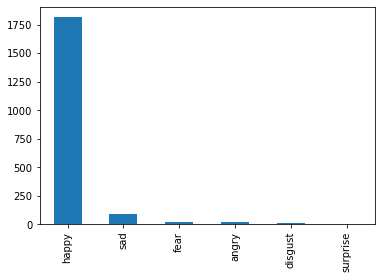

In [172]:
df['class'].value_counts().plot(kind='bar')

In [174]:
df.to_csv("washington_post_nuanced_sentiment_analysis_using_own_model.csv", index=False)

## Topic Modelling with Noun only

In [87]:
def get_noun(text):
    return ' '.join(word.text for word in nlp(text) if word.pos_ == 'NOUN')

In [88]:
data = df.copy()
data.head()

,category,sub_category,title,teaser content,article_body,complete_article
0,Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...,daily bidens yemen policy break obama daylight...
1,Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...,technology tech company airwave super bowl lv ...
2,Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...,energy democrats try filibuster climate change...
3,Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...,health biden narrow pick lead medicare medicai...
4,Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private...",cybersecurity coronavirus pandemic renew debat...


In [89]:
data.complete_article = data.complete_article.apply(get_noun)
data.head()

,category,sub_category,title,teaser content,article_body,complete_article
0,Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...,yemen policy break daylight newsletter today d...
1,Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...,technology tech company bowl lv tech company b...
2,Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...,energy filibuster climate change lawmaker weig...
3,Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...,health pick lead medicare medicaid choice admi...
4,Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private...",cybersecurity coronavirus pandemic debate d co...


## Only Nouns Frequency Graph and Word Clouds

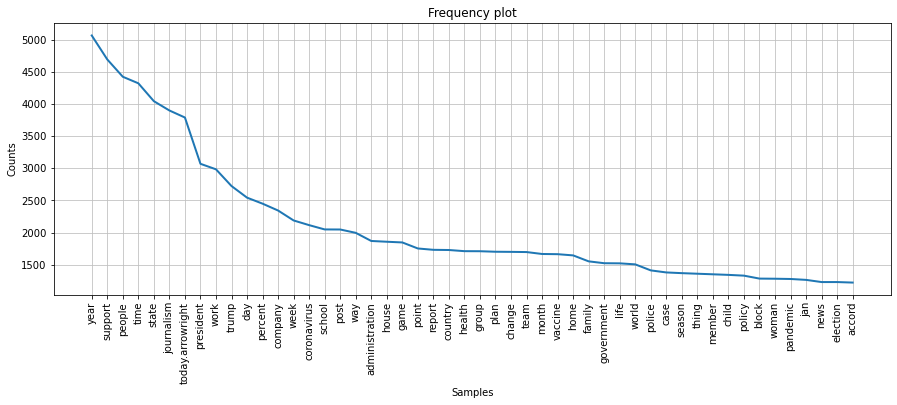

<AxesSubplot:title={'center':'Frequency plot'}, xlabel='Samples', ylabel='Counts'>

In [90]:
comment = ' '.join(data["complete_article"])
#function to split text into word
tokens = word_tokenize(comment)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)
plt.subplots(figsize=(15,5))
frequency_dist.plot(50,cumulative=False,title='Frequency plot')

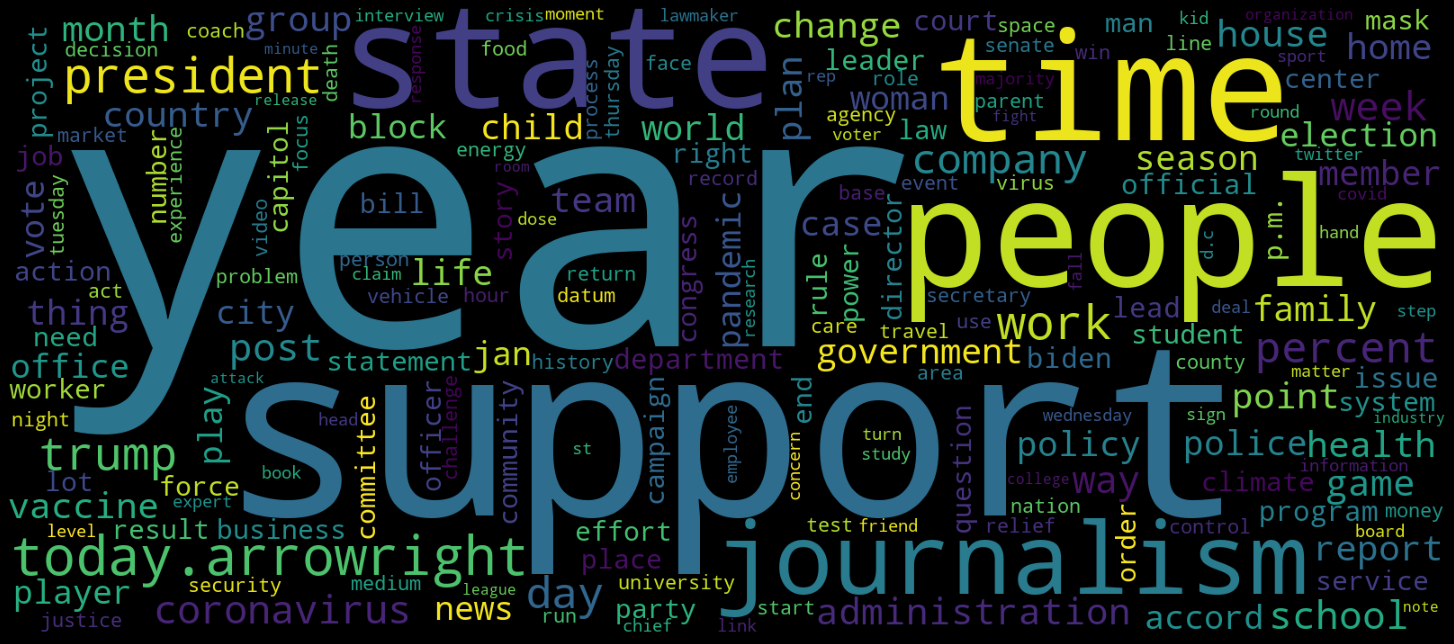

In [91]:
wordcloud = WordCloud(width=1600, height=700).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [92]:
data_1 = data.copy()
data_1.complete_article = data_1.complete_article.replace('', np.nan)
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)
data_1.shape

(1961, 6)

### Find optimal number of topics

In [93]:
from gensim.models import CoherenceModel

In [94]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
documents = [doc.split() for doc in data_1.complete_article]
id2word = corpora.Dictionary(documents)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [id2word.doc2bow(doc) for doc in documents]

In [95]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [96]:
mallet_path = 'mallet-2.0.8/bin/mallet'

In [97]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=doc_term_matrix, texts=documents, start=2, limit=100, step=6)

In [98]:
import matplotlib.pyplot as plt

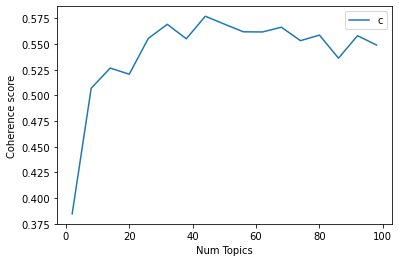

In [99]:
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [100]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3846
Num Topics = 8  has Coherence Value of 0.5069
Num Topics = 14  has Coherence Value of 0.5266
Num Topics = 20  has Coherence Value of 0.5206
Num Topics = 26  has Coherence Value of 0.5554
Num Topics = 32  has Coherence Value of 0.5692
Num Topics = 38  has Coherence Value of 0.5551
Num Topics = 44  has Coherence Value of 0.577
Num Topics = 50  has Coherence Value of 0.5693
Num Topics = 56  has Coherence Value of 0.5619
Num Topics = 62  has Coherence Value of 0.5617
Num Topics = 68  has Coherence Value of 0.5663
Num Topics = 74  has Coherence Value of 0.5532
Num Topics = 80  has Coherence Value of 0.5587
Num Topics = 86  has Coherence Value of 0.5362
Num Topics = 92  has Coherence Value of 0.558
Num Topics = 98  has Coherence Value of 0.549


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 50 topics itself.

In [101]:
from pprint import pprint

In [117]:
# Select the model and print the topics
optimal_model = model_list[8]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(26,
  '0.047*"health" + 0.043*"people" + 0.042*"coronavirus" + 0.032*"virus" + '
  '0.021*"case" + 0.018*"covid" + 0.016*"expert" + 0.014*"pandemic" + '
  '0.013*"mask" + 0.012*"study"'),
 (25,
  '0.095*"woman" + 0.026*"life" + 0.025*"man" + 0.019*"year" + 0.018*"father" '
  '+ 0.014*"work" + 0.014*"mother" + 0.011*"time" + 0.010*"job" + '
  '0.010*"journalism"'),
 (42,
  '0.077*"home" + 0.040*"house" + 0.025*"work" + 0.020*"room" + 0.019*"office" '
  '+ 0.018*"place" + 0.017*"window" + 0.013*"support" + '
  '0.013*"today.arrowright" + 0.012*"floor"'),
 (33,
  '0.073*"mask" + 0.028*"transportation" + 0.021*"face" + 0.020*"agency" + '
  '0.017*"passenger" + 0.016*"airline" + 0.016*"train" + 0.015*"metro" + '
  '0.014*"order" + 0.014*"mandate"'),
 (46,
  '0.038*"dog" + 0.018*"lot" + 0.015*"thing" + 0.014*"today.arrowright" + '
  '0.013*"cat" + 0.011*"journalism" + 0.011*"support" + 0.010*"war" + '
  '0.010*"day" + 0.010*"time"'),
 (24,
  '0.034*"music" + 0.025*"song" + 0.016*"band" + 0

In [103]:
countVectorizer = CountVectorizer()
termFrequency = countVectorizer.fit_transform(data_1.complete_article)
featureNames = countVectorizer.get_feature_names()

In [118]:
lda = LatentDirichletAllocation(n_components=50, max_iter=10)
lda.fit(termFrequency)

LatentDirichletAllocation(n_components=50)

In [119]:
nmf = NMF(n_components=50, max_iter=5000)
data_nmf = nmf.fit_transform(termFrequency) 

In [120]:
lsi = TruncatedSVD(n_components=50)
data_lsi = lsi.fit_transform(termFrequency)

In [121]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [122]:
print("LDA Model:")
selected_topics(lda, countVectorizer)

LDA Model:
Topic 0:
[('area', 183.7170112584711), ('title', 87.66357226269965), ('lane', 86.3902953055955), ('dr', 76.31175086994108), ('crash', 65.07596832432536), ('slam', 63.154335258024545), ('city', 60.62923178449441), ('escooter', 54.734036614828845), ('park', 48.00129381086262), ('st', 42.619450473363955)]
Topic 1:
[('travel', 387.5929864814002), ('time', 229.75658213642743), ('people', 199.98794539036984), ('sleep', 158.65218728688504), ('trip', 156.24268108062626), ('health', 135.81065718577005), ('day', 126.05736597392016), ('winter', 118.61336374239713), ('plan', 98.05772605258558), ('park', 89.70794594127632)]
Topic 2:
[('percent', 373.7227133809818), ('economy', 230.79844127214585), ('year', 196.88339226110728), ('job', 160.82014980778504), ('loan', 156.32290745507217), ('debt', 152.71472545971153), ('business', 146.80633820310402), ('rate', 137.66142403923666), ('interest', 108.10926041529004), ('bank', 98.78564598462285)]
Topic 3:
[('metro', 96.5950996139466), ('station'

[('doctor', 207.6559695140574), ('year', 144.66012745962772), ('pain', 138.85212110880104), ('patient', 100.46365731933672), ('time', 93.25865512469525), ('diagnosis', 90.86369219129483), ('disease', 90.05686920352598), ('test', 84.9787447646228), ('month', 83.1329365468117), ('cancer', 81.08499261344771)]
Topic 27:
[('fight', 172.22845778568612), ('goal', 90.28230162192209), ('year', 80.48668613609541), ('link', 66.64941823579382), ('life', 58.19650728778216), ('fighter', 53.58201517217839), ('round', 51.85265091709983), ('sauce', 50.11344463369908), ('card', 44.92253737488039), ('time', 44.80557269492097)]
Topic 28:
[('point', 364.7090484947634), ('fantasy', 249.57473921616267), ('project', 232.86229328195182), ('season', 106.58958450738308), ('percent', 61.98410181336582), ('year', 52.594662022295694), ('today', 52.56193215446239), ('arrowright', 50.60590878442409), ('game', 49.40619049212842), ('journalism', 49.38018663362592)]
Topic 29:
[('percent', 443.97758172165186), ('voter', 

In [123]:
print("NMF Model:")
selected_topics(nmf, countVectorizer)

NMF Model:
Topic 0:
[('vote', 11.027637086209289), ('bill', 10.686469632471953), ('senate', 8.423742760387652), ('relief', 8.040824285313876), ('budget', 7.87947831447487), ('plan', 7.433614988573447), ('support', 5.997894755057226), ('amendment', 5.893847960055223), ('package', 5.891701186564183), ('president', 5.758396078498657)]
Topic 1:
[('block', 20.157255200445896), ('st', 12.786108278476421), ('vehicle', 7.821863908771742), ('th', 3.7094085377512975), ('ave', 3.697872691647067), ('rd', 1.84993774733659), ('gun', 1.806831853831655), ('pl', 1.6149369547748313), ('unit', 1.0051317416664056), ('knife', 0.5613562254973693)]
Topic 2:
[('vaccine', 9.723554970418471), ('coronavirus', 7.729697522681718), ('dose', 7.686294112559254), ('state', 4.92125043976428), ('people', 4.308714132956061), ('variant', 3.8394085514443974), ('year', 3.7638825866226386), ('vaccination', 3.3954373377912335), ('worker', 3.004629208894872), ('government', 2.9990075750681617)]
Topic 3:
[('fantasy', 10.9683858

[('vaccine', 14.207000234465248), ('health', 6.923199690424884), ('dose', 4.663991654671735), ('coronavirus', 4.19696274070274), ('report', 2.0557957185676954), ('shot', 2.0291601484939803), ('virus', 2.0289973914315778), ('vaccination', 2.0226688929395613), ('people', 1.8916041437666076), ('supply', 1.5569701675704797)]
Topic 27:
[('woman', 13.51367638142366), ('harassment', 6.263585723723741), ('work', 4.242758764831968), ('abuse', 3.4780068506160986), ('policy', 3.239933131206124), ('man', 3.0398526463673288), ('victim', 2.523761846394668), ('way', 2.4535563369738767), ('organization', 2.3379150787362577), ('job', 2.1739313273369305)]
Topic 28:
[('mask', 14.366852653591552), ('transportation', 3.6501177241660985), ('passenger', 3.429295562753888), ('face', 2.8235737619945778), ('order', 2.572111099065753), ('bus', 2.227591209662808), ('agency', 2.126293520952237), ('metro', 1.9250146094510694), ('mandate', 1.87899768648012), ('transit', 1.83181065495051)]
Topic 29:
[('app', 12.64524

In [124]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=doc_term_matrix, texts=data_1)

In [125]:
df_topic_sents_keywords.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,category,sub_category,title,teaser content,article_body,complete_article
0,20.0,0.1565,"group, president, news, briefing, plan, house,...",Politics,Congress,The Daily 202: Biden’s Yemen policy breaks wit...,"Welcome to The Daily 202 newsletter! Today, we...",Support our journalism. Subscribe today.arrow-...,yemen policy break daylight newsletter today d...
1,0.0,0.4674,"company, facebook, account, twitter, tech, rep...",Politics,Congress,The Technology 202: Tech companies will be tak...,Tech companies will dominate the airwaves duri...,Meanwhile other large tech companies that have...,technology tech company bowl lv tech company b...
2,15.0,0.2439,"climate, energy, change, gas, carbon, emission...",Politics,Congress,The Energy 202: How Democrats may try getting ...,Some Democratic lawmakers are throwing their w...,Standing in his way is the Senate filibuster...,energy filibuster climate change lawmaker weig...
3,8.0,0.3925,"vaccine, coronavirus, state, dose, health, peo...",Politics,Congress,The Health 202: Biden narrows picks to lead Me...,The Biden administration has narrowed its sear...,Both women worked at the sweeping agency dur...,health pick lead medicare medicaid choice admi...
4,0.0,0.4397,"company, facebook, account, twitter, tech, rep...",Politics,Congress,The Cybersecurity 202: Coronavirus pandemic re...,Coronavirus has brought more scams than any ev...,"AD AD AD Right now, the government and private...",cybersecurity coronavirus pandemic debate d co...


<AxesSubplot:>

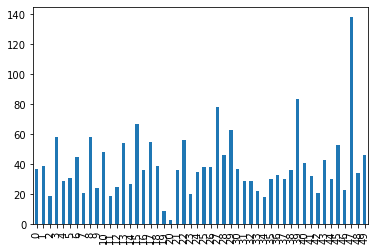

In [126]:
df_topic_sents_keywords.Dominant_Topic.astype('int').value_counts().plot(kind='bar')

## Topic count by sub_category

In [127]:
plots_data = df_topic_sents_keywords.groupby(['sub_category', 'Dominant_Topic'])['Dominant_Topic'].count()

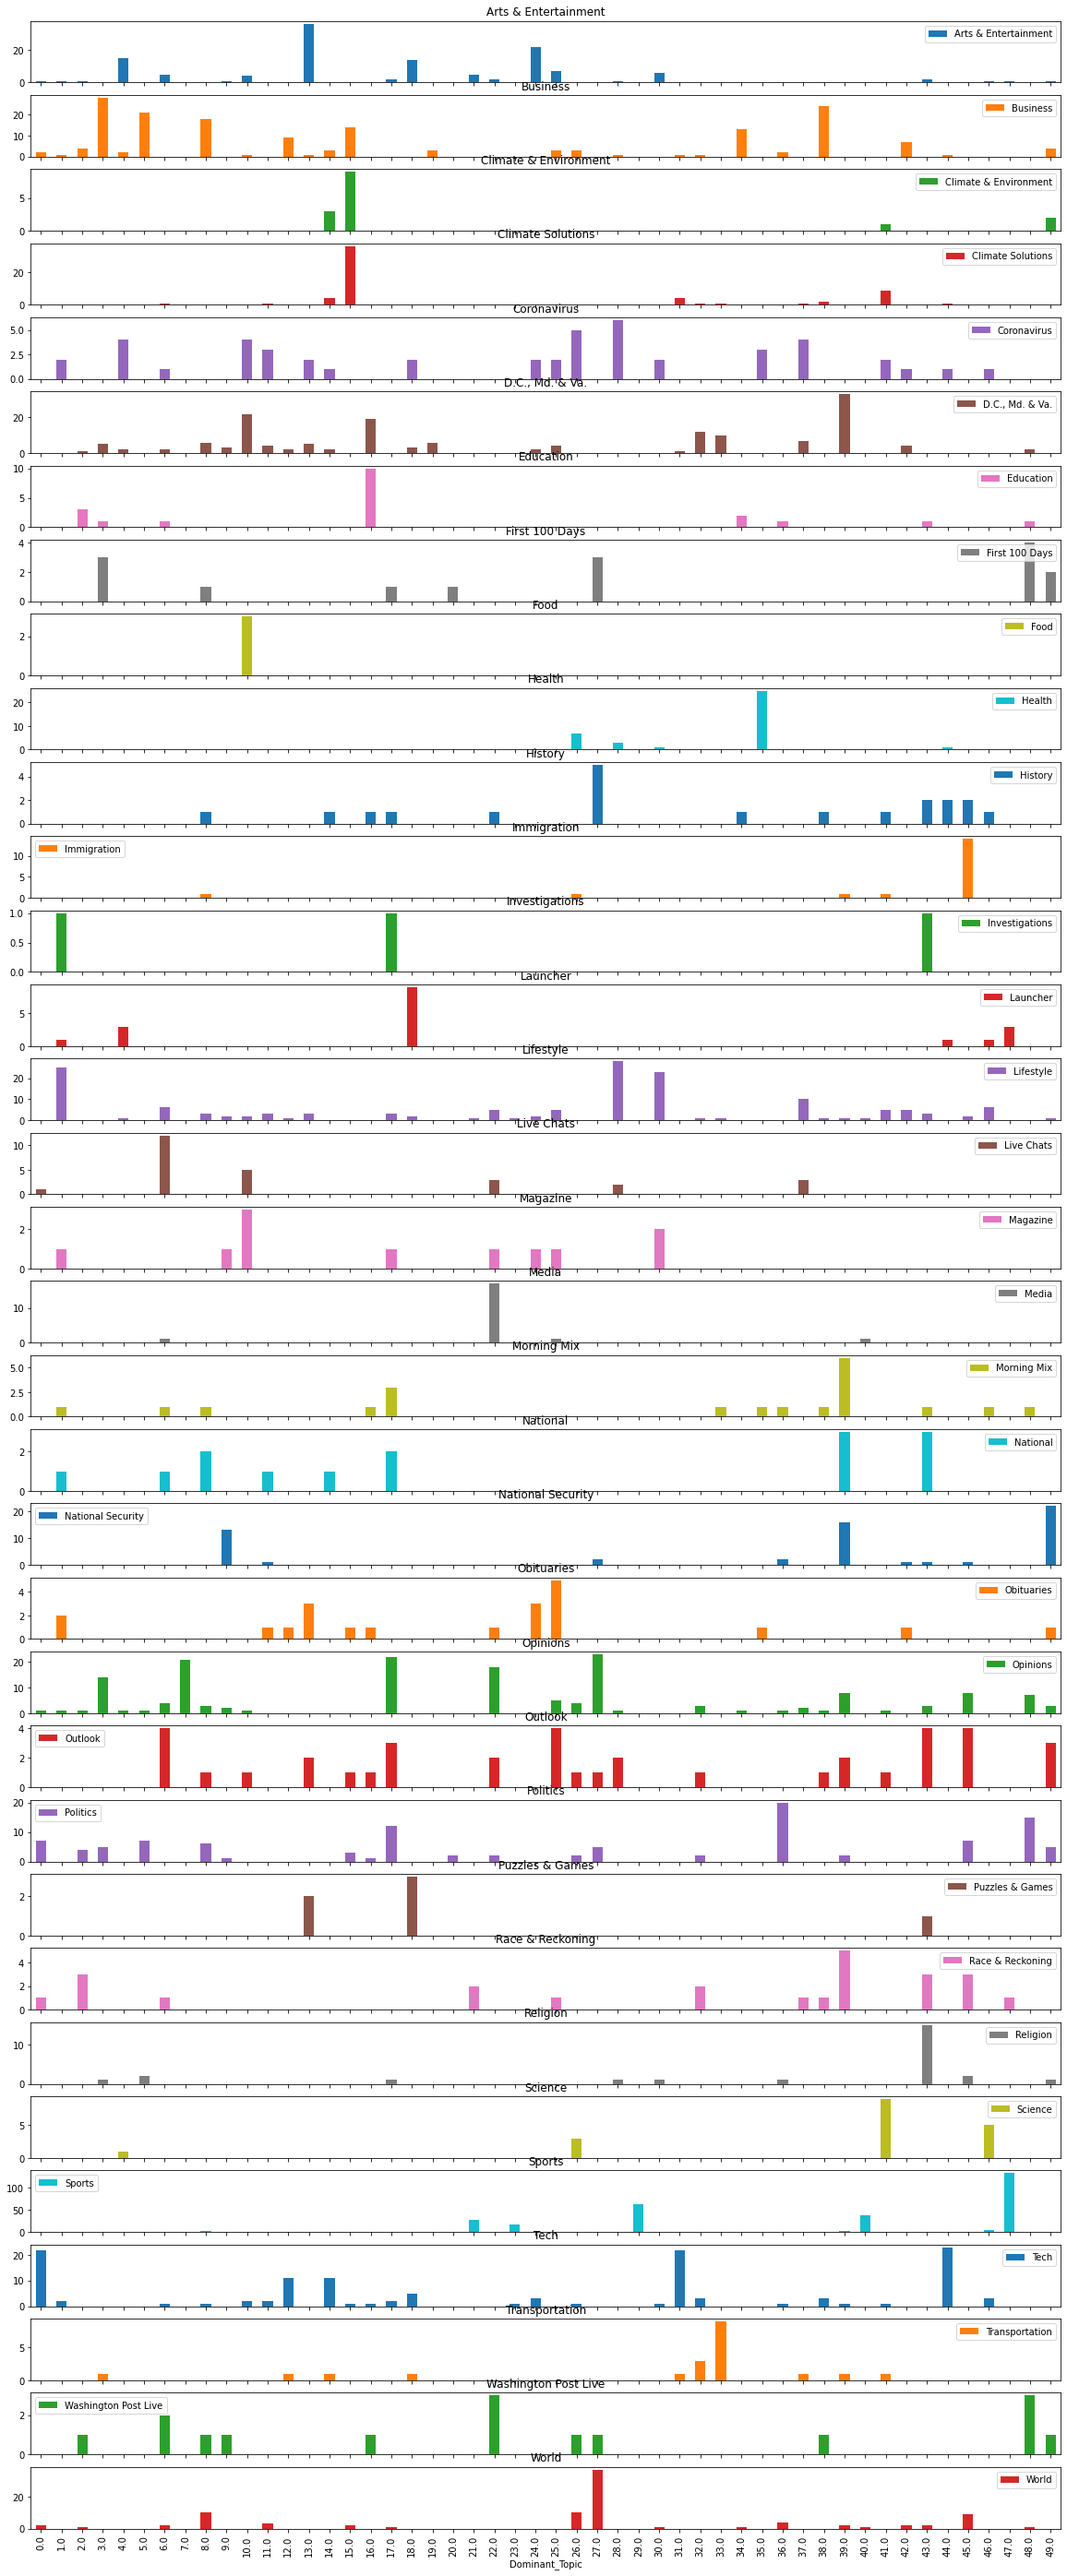

In [131]:
plots_data.unstack(level=0).plot(kind='bar', subplots=True, figsize=(20,50))
plt.show()

## Topic count by category

In [129]:
plots_data = df_topic_sents_keywords.groupby(['category', 'Dominant_Topic'])['Dominant_Topic'].count()

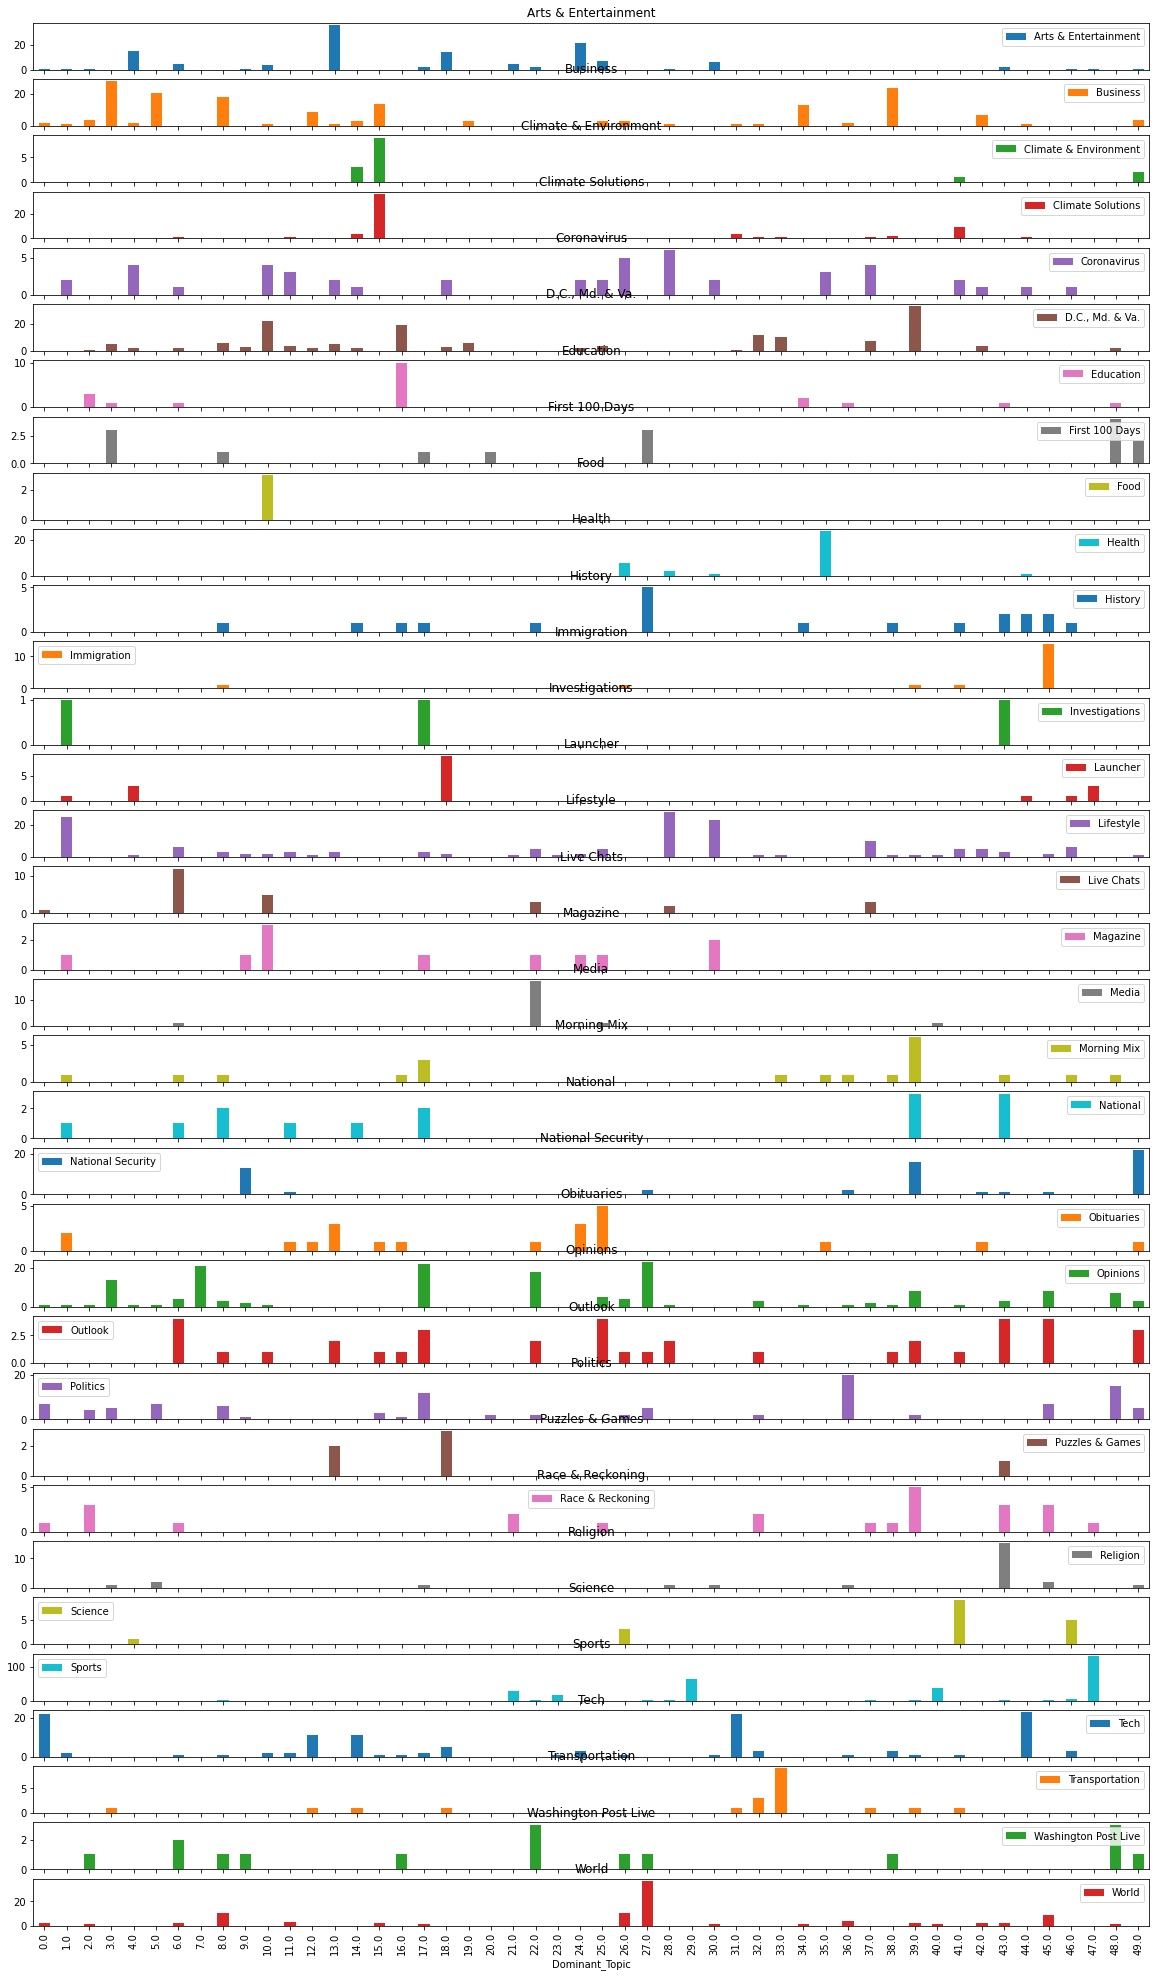

In [130]:
plots_data.unstack(level=0).plot(kind='bar', subplots=True, figsize=(20,35))
plt.show()

In [134]:
df_topic_sents_keywords.to_csv('washington_post_topic_modelling.csv', index=False)